In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import scipy
from scipy import signal
import librosa
import librosa.display
import os

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [3]:
import scipy as sp
from scipy import signal

def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [74]:
#get the chestband signal
#df = pd.read_csv("SpiroMask-July2021/chestBandData/Yash_Tidal_N95_GT_3_still.csv", names=['X','Y','Z'])
#df = pd.read_csv('SpiroMask-July2021/chestBandData/sensorlog_20210721_155550_Nipun.csv')
#df = df[0:2000]
#sr=100
#df['Time'] = [s/sr for s in range(0,df.shape[0])]

In [7]:
mypath="SpiroMask-July2021/SmartMaskData/Tidal/N95/"
(_, _, filenames) = next(os.walk(mypath))

In [14]:
for file in filenames:
    print(file.split('.'))

['Hatim01', 'Tidal_N95', '07', 'RCL', 'wav']
['Hatim02', 'Tidal_N95', '07', 'RCL', 'wav']
['Hatim03', 'Tidal_N95', '08', 'LCL', 'wav']
['Hatim04', 'Tidal_N95', '08', 'LCL', 'wav']
['Maithili01', 'Tidal_N95', 'RCL', 'wav']
['Maithili02', 'Tidal_N95', 'RCL', 'wav']
['Maithili03', 'Tidal_N95', 'RCL', 'wav']
['Maithili04', 'Tidal_N95', 'CL', 'wav']
['Maithili05', 'Tidal_N95', 'CL', 'wav']
['Rahul01', 'Tidal_N95', '08', 'RCL', 'wav']
['Rahul02', 'Tidal_N95', '05', 'RCL', 'wav']
['Rahul03', 'Tidal_N95', '00', 'LCL', 'wav']
['Rahul04', 'Tidal_N95', '00', 'LCL', 'wav']
['Sandra01', 'Tidal_N95', '10', 'RCL', 'wav']
['Sandra02', 'Tidal_N95', '08', 'RCL', 'wav']
['Sandra03', 'Tidal_N95', '10', 'LCL', 'wav']
['Sandra04', 'Tidal_N95', '10', 'LCL', 'wav']
['ShikhaD01', 'Tidal_N95', 'LCL', 'wav']
['ShikhaD02', 'Tidal_N95', 'LCL', 'wav']
['ShikhaD03', 'Tidal_N95', 'CL', 'wav']
['ShikhaD04Tidal_N95', 'CL', 'wav']
['Suvigya01', 'Tidal_N95', '04', 'RCL', 'wav']
['Suvigya02', 'Tidal_N95', '12', 'RCL', 'wa

In [9]:
filenamesLCL = [file for file in filenames if file.split('.')[3] == 'LCL']

IndexError: list index out of range

Approximate breathing cylces =  7


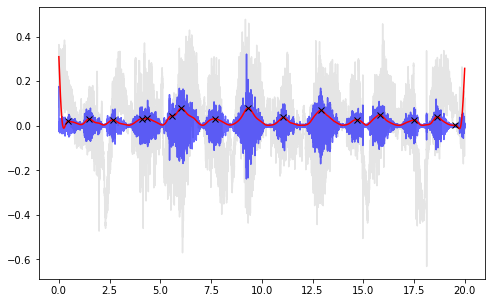

In [4]:
#now get the tidal breathing signal
#cutoff_low = 100 
#cutoff_high = 900
#order = 2
fs = 16000

tidal, sr = librosa.load('SpiroMask-July2021/SmartMaskData/Tidal/N95/Hatim01.Tidal_N95.07.RCL.wav')
tidal = tidal[0:fs*20]
tidal_t = [s/fs for s in range(0,len(tidal))]

#filtering using band passfilter
#tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)

imfs = emd(tidal, nIMF = 6)
#apply hilbert transform

x_filt_hilbert = signal.hilbert(imfs[2])
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks,_ = find_peaks(envelope_hat_filt)

'''
ax[0].plot(tidal_t, imfs[0],'b', alpha=0.6)
ax[0].plot(tidal_t, tidal,'k', alpha=0.1);
ax[1].plot(tidal_t, imfs[1],'b', alpha=0.6)
ax[1].plot(tidal_t, tidal,'k', alpha=0.1);
ax[2].plot(tidal_t, imfs[2],'b', alpha=0.6)
ax[2].plot(tidal_t, tidal,'k', alpha=0.1);
ax[3].plot(tidal_t, imfs[3],'b', alpha=0.6)
ax[3].plot(tidal_t, tidal,'k', alpha=0.1);
ax[4].plot(tidal_t, imfs[4],'b', alpha=0.6)
ax[4].plot(tidal_t, tidal,'k', alpha=0.1);
ax[5].plot(tidal_t, imfs[5],'b', alpha=0.6)
ax[5].plot(tidal_t, tidal,'k', alpha=0.1);
'''
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(tidal_t, tidal,'k', alpha=0.1);
ax.plot(tidal_t,imfs[2], 'b', alpha=0.6)
ax.plot(tidal_t,envelope_hat_filt,'r');
ax.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
print("Approximate breathing cylces = ",(len(peaks)-2)//2)

Signal is 20.0 seconds long
Approximate breathing cylces =  11


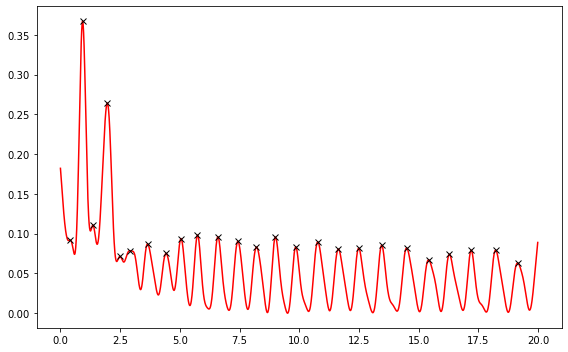

In [127]:
#df = pd.read_csv("SpiroMask-July2021/chestBandData/RahulKumar_Tidal_N95_GT_1.csv", names=['X','Y','Z'])
df = pd.read_csv("SpiroMask-July2021/chestBandData/sensorlog_20210721_155550_Nipun.csv")
df = df[0:2000]
sr=100
df['Time'] = [s/sr for s in range(0,df.shape[0])]

print("Signal is {} seconds long".format(df.shape[0]/sr))
#df.shape
#df = pd.read_csv('data/sensorlog_20210721_155550_Nipun.csv')
#df.index = df.Timestamp
#df = df.drop(['Timestamp'], axis=1)
#df.index = pd.to_datetime(df.index)

#filter using convolution
#size = 2
#window = np.ones(size)/size
#window = scipy.signal.gaussian(M=size, std=6)
#window /= window.sum()
#filtered = np.convolve(df['Z'], window, mode='valid')


#fig, ax = plt.subplots(4,1,figsize=(25,10))
#peaks,_ = find_peaks(filtered)
#ax[0].plot(df['Z'], color='red');

FS, HS = compute_fft(df['Z'], 100, scale_amplitudes=True)
#ax[1].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
#ax[1].set_xlabel('Frequencies')
#ax[1].set_ylabel('Amplitude');

cutoff_low = 5 
cutoff_high = 40
order = 5

filteredHP = butter_bandpass_filter(df['Z'],cutoff_low,cutoff_high,sr,order)

FS, HS = compute_fft(filteredHP, 100, scale_amplitudes=True)
#ax[2].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
#ax[2].set_xlabel('Frequencies')
#ax[2].set_ylabel('Amplitude');
#ax[3].plot(range(0, (len(df.Time)-100)), filteredHP[100:], color='red');

#apply hilbert transform
fig, ax = plt.subplots(1,1, figsize=(8,5))
x_filt_hilbert = signal.hilbert(filteredHP)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = sr /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)

#find peaks
peaks,_ = find_peaks(envelope_hat_filt)

#ax.plot([s/fs for s in range(0,len(filteredHP))],envelope_hat_filt,'r')
ax.plot(df['Time'],envelope_hat_filt,'r')
ax.plot(df['Time'][peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
print("Approximate breathing cylces = ",(len(peaks)-2)//2)
fig.tight_layout();
